### Libraries

In [1]:
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from bisect import bisect_left
from itertools import chain
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import artm
import csv
import re

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Скопируем в локальные директории данные по ссылке https://disk.yandex.ru/d/bwUVH8hR1MRNrg.

### Dataset & general parameters + Bigartm

Используем заранее преобразованные токены из семинара по тематическому моделированию.

In [3]:
with open('topicmodeling/lenta-ru-proccess.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    data = pd.DataFrame(reader)

data['month'] = data.apply(lambda row: int(row['date'].split('-')[1]), axis=1)
data['year'] = data.apply(lambda row: int(row['date'].split('-')[2]), axis=1)

all_years = sorted(data['year'].unique())[1:]
all_years_lables = list(map(str, all_years))
print(data, all_years)

                                                     text      tags   len  \
0       1 сентябрь весь территория россия вводиться но...       Все  1654   
1       сведение миссия оон , передаваемый риа " новос...       Все  1086   
2       15 представитель национал - большевистский пар...       Все  1219   
3       наметить сегодняшний день церемония вступление...       Все  3094   
4       юг киргизия , именно баткенский чон - алайском...       Все  1354   
...                                                   ...       ...   ...   
863280  популярный место среди турист мурманский облас...    Россия  1231   
863281  рейтинг международный рейтинговый агентство s ...            1425   
863282  российский учёный найти якутия новый подвид ар...   События  1299   
863283  указание коронавирус причина смерть человек не...  Общество  2061   
863284  президент сша дональд трамп стать посредник но...  Политика  1020   

              date  month  year  
0       31-08-1999      8  1999  
1      

Генерируем выборки для тестов и обучения, заодно отсекая мелкие тексты и приводя данные к виду, необходимому для `bigartm`.

Модальности будем добавлять по одной по-очерёдно, чтобы не пришлось проверять все возможные комбинации. Используем тег и год как 2 различные модальности.

In [5]:
def get_modalities_str(data, modalities: list):
    name = ""
    if modalities != None:
        for mod in modalities:
            if mod != None:
                name += f"|@{mod} class_{data[mod]} "

    return name

In [4]:
def get_years(data, train_mask):
    year_train = []
    year_test = []

    for i in tqdm(range(len(data))):
        text = data.loc[i]['text']
        text = (split_regexp.sub(' ', text).strip()).split()

        # Drop small texts
        if len(text) < 90:
            continue

        text = ' '.join(text)
        year = data.loc[i]['year']

        if train_mask[i]:
            year_train.append(year)
        else:
            year_test.append(year)

    return year_train, year_test

In [13]:
def create_bigartm_format_files(data, file_train, file_test, train_mask, modalities=None):
    years_train = 0
    years_test = 0

    with open(file_train, 'w') as ftrain, open(file_test, 'w') as ftest:
        for i in tqdm(range(len(data))):
            text = data.loc[i]['text']
            text = (split_regexp.sub(' ', text).strip()).split()

            # Drop small texts
            if len(text) < 90:
                continue

            text = ' '.join(text)

            if train_mask[i]:
                sample_name = f'doc_{years_train} {text} ' + get_modalities_str(data.loc[i], modalities)
                ftrain.write(sample_name + '\n')
                years_train += 1
            else:
                sample_name = f'doc_{years_test} {text} ' + get_modalities_str(data.loc[i], modalities)
                ftest.write(sample_name + '\n')
                years_test += 1

In [28]:
train_mask = np.random.default_rng(1).random(len(data)) < 0.85
split_regexp = re.compile(r'\W+')

year_train, year_test = get_years(data, train_mask)
print(len(year_train), len(year_test))

100%|██████████| 863285/863285 [01:07<00:00, 12799.65it/s]

622314 109888


In [6]:
modalities_list = [None, "year", "tags"]

In [16]:
for mod in modalities_list:
    if mod == None:
        mod_name = "nomod"
    else:
        mod_name = mod

    create_bigartm_format_files(data,
        file_train='topicmodeling/vw_data/texts_train_' + mod_name + '.vw.txt',
        file_test='topicmodeling/vw_data/texts_test_' + mod_name + '.vw.txt',
        train_mask=train_mask, modalities=[mod])

100%|██████████| 863285/863285 [01:16<00:00, 11350.58it/s]


Формируем/грузим батчи в формате, используемом библиотекой `bigartm`.

In [17]:
# Create batches files from train/test files

for mod in modalities_list:
    if mod == None:
        mod_name = "nomod"
    else:
        mod_name = mod

    _ = artm.BatchVectorizer(data_path='topicmodeling/vw_data/texts_train_' + mod_name + '.vw.txt',
                             data_format='vowpal_wabbit', batch_size=10000,
                             target_folder='topicmodeling/batches_train_' + mod_name)

    _ = artm.BatchVectorizer(data_path='topicmodeling/vw_data/texts_test_' + mod_name + '.vw.txt',
                             data_format='vowpal_wabbit', batch_size=10000,
                             target_folder='topicmodeling/batches_test_' + mod_name)

### Bigartm models

Обучим модели для каждого из регулиризаторов (и без них) параллельно с введением дополнительных модальностей.

In [7]:
regul_list = [
    [None, 'noreg'],
    [artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5), 'decor_phi'],
    [artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=15), 'sm_sp_phi'],
    [artm.ImproveCoherencePhiRegularizer(name='ImproveCoherencePhi', tau=20), 'impr_coh_phi']
]

In [10]:
# Code below was used bacause of crashed kernel
# modalities_list = ["tags"]

for mod in modalities_list:
    if mod == None:
        mod_name = "nomod"
    else:
        mod_name = mod

    bv_train = artm.BatchVectorizer(data_path='topicmodeling/batches_train_' + mod_name,
                                    data_format='batches')
    dictionary = artm.Dictionary()
    dictionary.gather(data_path='topicmodeling/batches_train_' + mod_name)

    for reg in regul_list:

        if mod != None:
            model = artm.ARTM(num_topics=178, dictionary=dictionary,
                              class_ids={'@default_class': 1.0, f'@{mod_name}': 27.0})
        else:
            model = artm.ARTM(num_topics=178, dictionary=dictionary,
                              class_ids={'@default_class': 1.0})

        model_name = f'{mod_name}_{reg[1]}'

        model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
        model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
        if mod != None:
            model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id=f'@{mod_name}'))

        if reg[0] != None:
            model.regularizers.add(reg[0])

        iterator = tqdm(range(13))
        for i in iterator:
            model.fit_offline(bv_train, num_collection_passes=1)
            if mod == None:
                iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1]})
            else:
                iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],
                                      'sparsity': model.score_tracker['sparsity'].value[-1]})

        #model.dump_artm_model(f'/content/drive/MyDrive/Colab Notebooks/topicmodeling/model/{model_name}')
        model.dump_artm_model(f'topicmodeling/model/{model_name}')

100%|██████████| 13/13 [07:11<00:00, 33.17s/it, perplexity=558, sparsity=0.959]    


### Year as modality (classification analyses)

In [29]:
model = artm.load_artm_model(f'topicmodeling/model/year_noreg')
dictionary = artm.Dictionary()
dictionary.gather(data_path='topicmodeling/batches_train_year')

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id=f'@year'), overwrite=True)

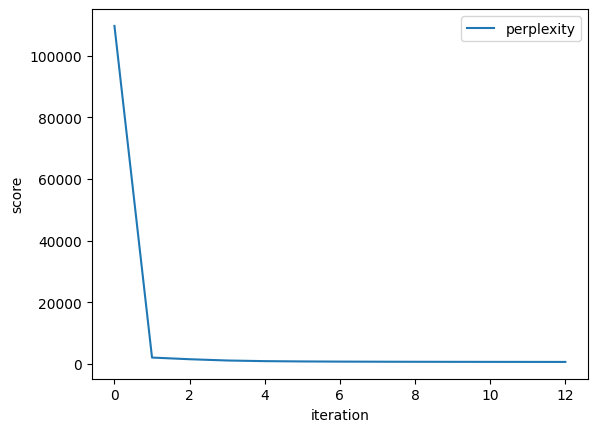

In [10]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

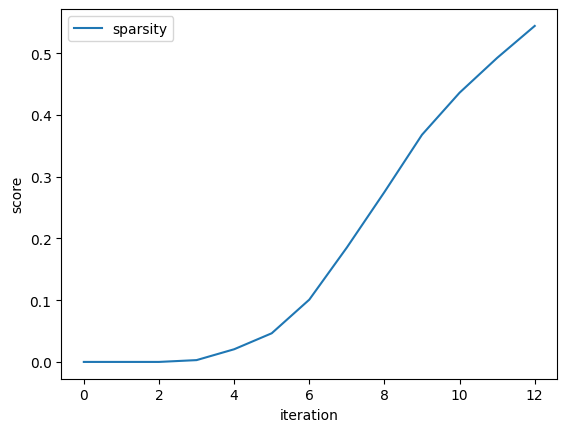

In [11]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

### Topic modeling (texts -> topic vectors)

In [15]:
def create_dataset(artm: artm.ARTM, bv: artm.BatchVectorizer, years: list):
    values = np.array(artm.transform(bv).values).T
    dataset = []

    for i in range(len(values)):
        year_onehot = np.zeros(len(all_years), dtype='float32')
        year_onehot[bisect_left(all_years, years[i])] = 1.0
        dataset.append((values[i], year_onehot))

    return dataset

In [8]:
def create_X_data(artm: artm.ARTM, bv: artm.BatchVectorizer):
    return np.array(artm.transform(bv).values).T

### Training code

Используем `catboost` в качестве классификатора, печатаем качество классификации для каждой модели.

In [9]:
for mod in modalities_list:
    if mod == None:
        mod_name = "nomod"
    else:
        mod_name = mod

    bv_train = artm.BatchVectorizer(data_path='topicmodeling/batches_train_' + mod_name,
                                    data_format='batches')
    bv_test = artm.BatchVectorizer(data_path='topicmodeling/batches_test_' + mod_name,
                                   data_format='batches')

    for reg in regul_list:
        model_name = f'{mod_name}_{reg[1]}'
        model = artm.load_artm_model(f'topicmodeling/model/{model_name}')

        train_X_dataset = create_X_data(model, bv_train)
        test_X_dataset = create_X_data(model, bv_test)

        train_y_dataset = np.copy(year_train)

        train_X_dataset, train_y_dataset = shuffle(train_X_dataset, train_y_dataset, random_state=34)

        print("Train data length:", len(train_X_dataset), train_X_dataset.shape)
        print("Test data length:", len(test_X_dataset))

        clf = CatBoostClassifier(
            iterations=10,
            learning_rate=1,
            depth=2,
            loss_function='MultiClass'
        )

        clf.fit(train_X_dataset, train_y_dataset,
                verbose=False
        )

        #print(year_test[:100], clf.predict(test_X_dataset)[:100])

        report = classification_report(year_test, list(chain.from_iterable(clf.predict(test_X_dataset))), zero_division=0, target_names=all_years_lables)
        print(model_name)
        print(report)

E0502 18:10:34.074806  9424 perplexity.cc:52] Perplexity was configured to use UnigramCollectionModel with dictionary 71bec208-36b8-426d-b238-cae5cb5a767c. This dictionary can't be found.
E0502 18:10:34.075001  9424 perplexity.cc:52] Perplexity was configured to use UnigramCollectionModel with dictionary 71bec208-36b8-426d-b238-cae5cb5a767c. This dictionary can't be found.
E0502 18:10:34.075016  9424 perplexity.cc:52] Perplexity was configured to use UnigramCollectionModel with dictionary 71bec208-36b8-426d-b238-cae5cb5a767c. This dictionary can't be found.
E0502 18:10:34.075019  9424 perplexity.cc:52] Perplexity was configured to use UnigramCollectionModel with dictionary 71bec208-36b8-426d-b238-cae5cb5a767c. This dictionary can't be found.
E0502 18:10:34.075023  9424 perplexity.cc:52] Perplexity was configured to use UnigramCollectionModel with dictionary 71bec208-36b8-426d-b238-cae5cb5a767c. This dictionary can't be found.
E0502 18:10:34.075026  9424 perplexity.cc:52] Perplexity was

Train data length: 622314 (622314, 178)
Test data length: 109888
nomod_noreg
              precision    recall  f1-score   support

        1999       0.00      0.00      0.00       348
        2000       0.00      0.00      0.00      1331
        2001       0.00      0.00      0.00      1841
        2002       0.00      0.00      0.00      2273
        2003       0.00      0.00      0.00      2416
        2004       0.00      0.00      0.00      2905
        2005       0.00      0.00      0.00      3830
        2006       0.00      0.00      0.00      4341
        2007       0.00      0.00      0.00      4037
        2008       0.02      0.06      0.03      5889
        2009       0.06      0.08      0.07      6761
        2010       0.00      0.00      0.00      6155
        2011       0.03      0.00      0.01      6240
        2012       0.05      0.07      0.06      6499
        2013       0.00      0.00      0.00      6263
        2014       0.00      0.00      0.00      5091
    

### Conlusions

Был проводён ряд экспериментов:
  * Без модальности и с модальностями в виде года и тега (тематики) статьи.
  * Без регуляризаторов и с 3-мя: `DecorrelatorPhiRegularizer`, `SmoothSparsePhiRegularizer`, `ImproveCoherencePhiRegularizer`.

Выводы:
  * Встроенными методами `bigartm` получено, что при добавлении модельности года его sparsity (разреженность матрицы $\phi$) увеличивается и достагает значений >0.5, что означает хорошее предсказывание слов при заданной теме.
  * Регуляризаторы могут как улучшить, так и ухудшить сходимость моделей.
    * Из всех регуляризаторов худшим показал себя `SmoothSparsePhiRegularizer`, который занижает perplexity и не даёт расти sparsity, возможно выбран неверный параметр $\tau$.
    * Лучшим регуляризатором является `DecorrelatorPhiRegularizer`, который ускоряет возрастание sparsity с тем же порядком preplexity.
  * Ожидалось, что добавление модальностей существенным образом повлияет на качество конечной классификации, однако это не так. Качество классификации в среднем лучше, чем если бы года выбирались случайным образом, но одновременно остаётся ниже, чем ожидалось. Возможные причины такого поведения:
    * Слабая корреляция тем топиков и года их публикации, вес модальности года при обучении возможно следовало ставить больше, чтобы темы больше разбивались по годам.
    * Плохой метод классификации, но вместе с `catboost` были использованы ещё несколько других методов, в том числе нейронная сеть (подобие 3 семинара), все дают примерно схожий результат.

Все модели (12 штук) обучались 2 раза (на всякий случай), 1 раз локально (3 часа) и 1 раз на google collab (13 часов), все данные и батчи 10 раз проверены, ошибок быть не должно.